In [ ]:
from os import listdir
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

from GIST import GIST

from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize

# Imports for training a classifier with grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


In [ ]:
# Find the name of each class
base_path = "/content/.../caltech-101"
class_names = listdir(base_path)[:5]
print("Num of classes:", len(class_names))

Num of classes: 5


In [ ]:
# Load first 40 images from first class and a label for the class
X = []
Y = []
X_frec=[]
for clase in range(0,5):
    print(class_names[clase])
    file_names1 = [join(base_path, class_names[clase], f) for f in listdir(join(base_path, class_names[clase]))]
    X1 = np.array([resize(imread(f, as_gray='True'), (300, 200)) for f in file_names1[:40]])
    Y1 = np.full((len(X1)), clase)
    X_frec.append(len(X1))

    X.append(X1)  # Agregar los datos de la clase actual a la lista X
    Y.append(Y1)  # Agregar las etiquetas de la clase actual a la lista Y

X = np.concatenate(X)  # Convertir la lista de datos en un arreglo numpy
Y = np.concatenate(Y)  # Convertir la lista de etiquetas en un arreglo numpy

print(X.shape)
print(Y.shape)


ant
beaver
accordion
airplanes
barrel
(200, 300, 200)
(200,)


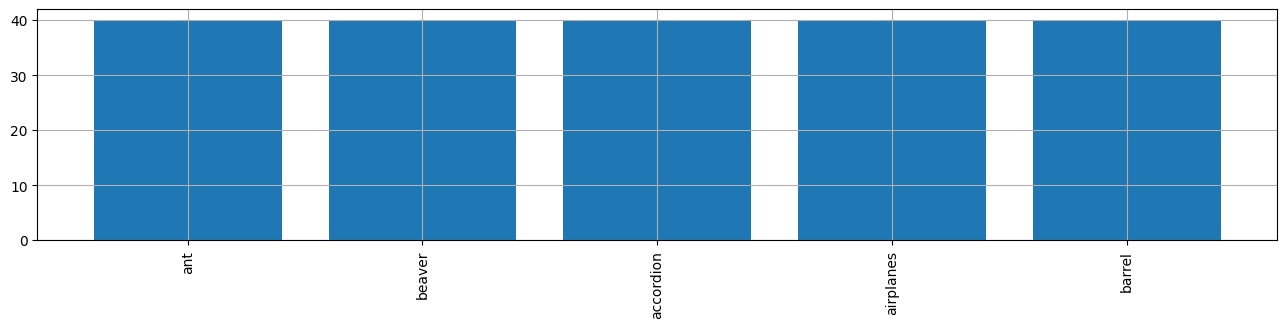

In [ ]:
plt.figure(figsize=(16, 3))
plt.bar(range(len(X_frec)), X_frec)
plt.xticks(range(len(X_frec)), class_names, rotation='vertical')
plt.grid()
plt.show()

# Classification with GIST and Gradient Boosting

In [ ]:
# Compute GIST for each image
param = {"orientationsPerScale":np.array([8, 8, 8, 8]),
         "numberBlocks":[4, 4],
         "fc_prefilt":10,
         "boundaryExtension":10}
gist = GIST(param)

X_gist = np.array([gist._gist_extract(resize(img, (349, 352))) for img in X]) # Try with different image size
print(X_gist.shape)

(200, 512)


In [ ]:
# Compute GIST descriptor for one example image
#primer_descriptor = X_gist[3, 1]
#print(primer_descriptor)

In [ ]:
# Split train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_gist, Y, test_size=0.1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(180, 512)
(20, 512)
(180,)
(20,)


In [ ]:
# Define grid search parameters
hyperparams = {'learning_rate': [0.001, 0.01, 0.1],
               'n_estimators': [2, 5, 10],   # 20, 30],
               'max_depth': range(2, 7),
               'min_samples_split': range(2, 7, 2),
               'min_samples_leaf': range(1, 6, 2),
               'max_features': [None, 'sqrt', 'log2']}
hyperparams

{'learning_rate': [0.001, 0.01, 0.1],
 'n_estimators': [2, 5, 10],
 'max_depth': range(2, 7),
 'min_samples_split': range(2, 7, 2),
 'min_samples_leaf': range(1, 6, 2),
 'max_features': [None, 'sqrt', 'log2']}

In [ ]:
# Create and train the classifiers with grid search
gs_model = GridSearchCV(GradientBoostingClassifier(), hyperparams, verbose=True, n_jobs=3)
gs_model.fit(x_train, y_train)

Fitting 5 folds for each of 1215 candidates, totalling 6075 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=3,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': range(2, 7),
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': range(1, 6, 2),
                         'min_samples_split': range(2, 7, 2),
                         'n_estimators': [2, 5, 10]},
             verbose=True)

**Tiempo de Entrenamiento**= 23 min

In [ ]:
# Print info about best model, its score and its hyperparameters
best_classifier = gs_model.best_estimator_

print(best_classifier)
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

GradientBoostingClassifier(max_features='sqrt', min_samples_leaf=3,
                           min_samples_split=6, n_estimators=10)
Best score: 0.861
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 10}


In [ ]:
# Evaluate on both training and test set
print(f"Train mean accuracy: {best_classifier.score(x_train, y_train):.3f}")
print(f"Test mean accuracy: {best_classifier.score(x_test, y_test):.3f}")

Train mean accuracy: 1.000
Test mean accuracy: 0.800


In [ ]:
# Let's see at the predicted classes
y_test_hat = best_classifier.predict(x_test)
print("Ground truth:", y_test)
print("Prediction  :", y_test_hat)

Ground truth: [2 1 3 0 2 1 3 1 1 1 2 4 4 4 4 3 2 3 1 3]
Prediction  : [2 1 3 0 2 0 3 1 1 1 2 4 4 1 0 3 2 3 4 3]


<Figure size 400x400 with 0 Axes>

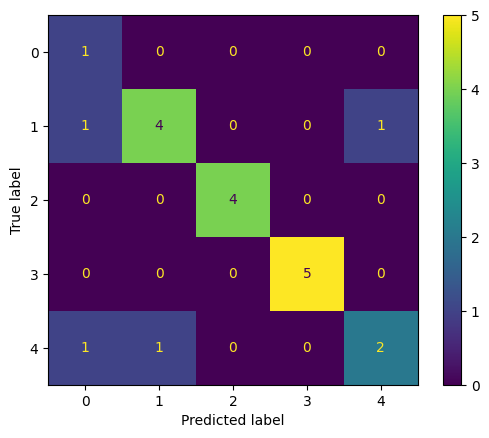

In [ ]:
# Confusion matrix
CM = confusion_matrix(y_test, y_test_hat, labels=best_classifier.classes_)

plt.figure(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=best_classifier.classes_)
disp.plot()
plt.show()

In [ ]:
# Define grid search parameters **********************************************
hyperparams = {'kernel': ['linear', 'poly', 'rbf'],
               'C': [0.01, 0.1, 1.0, 10, 100],
               'degree': [1, 2, 3, 4],
               'gamma': ['auto', 'scale'],
               'coef0': [1/4, 1/2, 1, 2]}
hyperparams

{'kernel': ['linear', 'poly', 'rbf'],
 'C': [0.01, 0.1, 1.0, 10, 100],
 'degree': [1, 2, 3, 4],
 'gamma': ['auto', 'scale'],
 'coef0': [0.25, 0.5, 1, 2]}

In [ ]:
# Create and train the classifiers with grid search
from sklearn.svm import SVC
gs = GridSearchCV(SVC(), hyperparams, verbose=True, n_jobs=-1)
gs.fit(x_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100],
                         'coef0': [0.25, 0.5, 1, 2], 'degree': [1, 2, 3, 4],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=True)

**Tiempo de EJecución**: 29 segundos

In [ ]:
# Print info about best score and best hyperparameters
print(f"Best score: {gs.best_score_:.3f}")
print(f"Best params: {gs.best_params_}")

Best score: 0.917
Best params: {'C': 10, 'coef0': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}


In [ ]:
# Evaluate on the test set
best_svm = gs.best_estimator_

print(f"Train mean accuracy: {best_svm.score(x_train, y_train):.3f}")
print(f"Test mean accuracy: {best_svm.score(x_test, y_test):.3f}")

Train mean accuracy: 1.000
Test mean accuracy: 0.850


In [ ]:
# Let's see at the predicted classes
y_test_hat = best_svm.predict(x_test)
print("Ground truth:", y_test)
print("Prediction  :", y_test_hat)

Ground truth: [2 1 3 0 2 1 3 1 1 1 2 4 4 4 4 3 2 3 1 3]
Prediction  : [2 1 3 1 2 1 3 4 1 1 2 4 4 1 4 3 2 3 1 3]


[[0 1 0 0 0]
 [0 5 0 0 1]
 [0 0 4 0 0]
 [0 0 0 5 0]
 [0 1 0 0 3]]


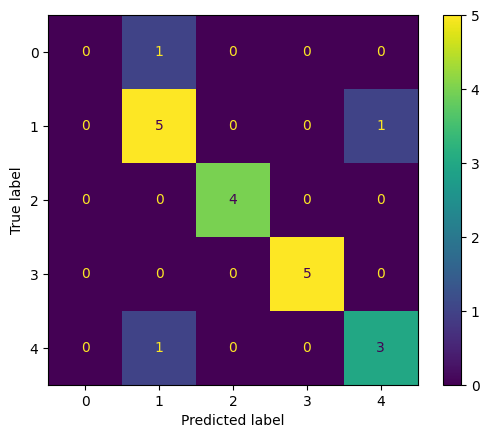

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion matrix
confusion_matrix = confusion_matrix(y_test, y_test_hat)
print(confusion_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix)
# Dibujar el gráfico de la matriz de confusión
cm_display.plot()
# Mostrar el gráfico
plt.show()